In [2]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd

#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'
stash_ems = 'm01s50i306'

#define constants
oh_mr = 17
n_a = 6.022e23
mr_ch4 = 16
per_sec_to_per_yr = 60*60*24*360
g_to_Tg = 1e12

# Altitude data to obtain volumes

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

# Convert methane input to ppb units
def ppb(conc_kg_kg,mr):
    g_bil = np.multiply(conc_kg_kg,28.97*1e9)
    parts_per_bil = np.divide(g_bil,mr) 
    return parts_per_bil

def Tg_yr_m3(conc_grd_s,vol,mr):
    flux_box = (conc_grd_s*mr*per_sec_to_per_yr)/g_to_Tg #Tg per year per box
    flux_m3 = flux_box/vol #Tg per year per m3
    return flux_m3

In [3]:
# Area and volume datasets

area = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area['areacella'][:]

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

# First calculate interhemispheric OH ratio

In [29]:
# oh data
oh_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_oh_PI.nc',chunks={'time':24})
oh_949 = oh_data_949[stash_oh][:]
time_949 = oh_data_949.time[:]
dtime_949 = nc.date2num(time_949,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

oh_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_oh.nc',chunks={'time':24})
oh_443 = oh_data_443.oh[:]
time_443 = oh_data_443.time[:]
dtime_443 = nc.date2num(time_443,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

# air mass data
data_air_mass_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_airmass_PI.nc', chunks={'time':12})
air_mass_949 = data_air_mass_949.variables[stash_mass][:]

data_air_mass_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_airmass_atm.nc',chunks={'time':12})
air_mass_443 = data_air_mass_443.variables['airmass_atm'][:]

In [30]:
# create tropospheric mask for calculations from o3 data
trop_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_trop_mask_PI.nc',chunks={'time':24})
trop_949 = trop_data_949[stash_trop]
trop_949 = trop_949.where(trop_949>0.99999,other=0.)

trop_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_trop_mask.nc',chunks={'time':24})
trop_443 = trop_data_443['trop_mask']
trop_443 = trop_443.where(trop_443>0.99999,other=0.)

In [31]:
# convert oh to molec cm-3 concentration then calculate interhemispheric ratio
conc_oh_949 = molec_cm3(oh_949,air_mass_949,vol,oh_mr)
conc_oh_443 = molec_cm3(oh_443,air_mass_443,vol,oh_mr)

# Calculate NH and SH mean [OH]
# bl949
nh_oh_949 = dd.array.average(conc_oh_949.loc[:,:,0:90,:],weights=trop_949.loc[:,:,0:90,:],axis=(1,3))
nh_oh_949 = dd.array.average(nh_oh_949,weights=lat_area_scaled[72:144],axis=1)

sh_oh_949 = dd.array.average(conc_oh_949.loc[:,:,-90:0,:],weights=trop_949.loc[:,:,-90:0,:],axis=(1,3))
sh_oh_949 = dd.array.average(sh_oh_949,weights=lat_area_scaled[0:72],axis=1)

# bh443
nh_oh_443 = dd.array.average(conc_oh_443.loc[:,:,0:90,:],weights=trop_443.loc[:,:,0:90,:],axis=(1,3))
nh_oh_443 = dd.array.average(nh_oh_443,weights=lat_area_scaled[72:144],axis=1)

sh_oh_443 = dd.array.average(conc_oh_443.loc[:,:,-90:0,:],weights=trop_443.loc[:,:,-90:0,:],axis=(1,3))
sh_oh_443 = dd.array.average(sh_oh_443,weights=lat_area_scaled[0:72],axis=1)

ratio_949 = np.divide(nh_oh_949,sh_oh_949).compute()
ratio_443 = np.divide(nh_oh_443,sh_oh_443).compute()

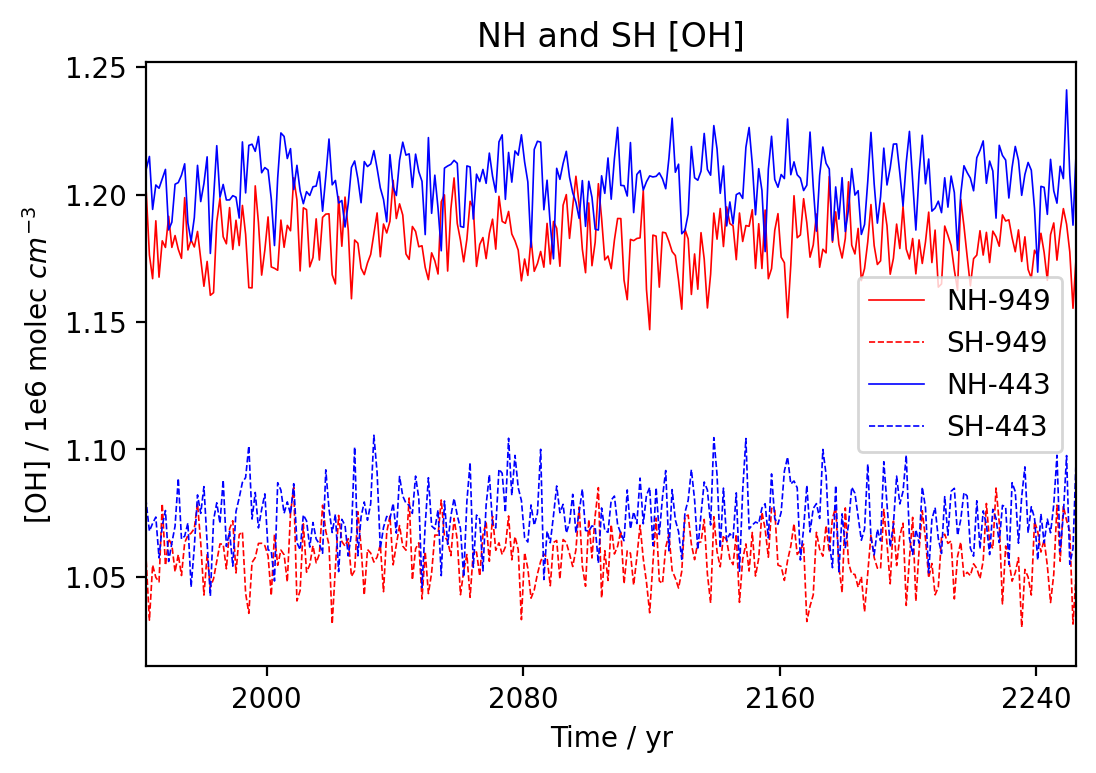

In [6]:
# Plot interhemispheric ratio over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('NH and SH [OH]')

ax.plot(time_949,nh_oh_949/1e6,linewidth=0.6,label='NH-949',c='r')
ax.plot(time_949,sh_oh_949/1e6,linewidth=0.6,label='SH-949',linestyle='dashed',c='r')

ax.plot(time_443,nh_oh_443/1e6,linewidth=0.6,label='NH-443',c='b')
ax.plot(time_443,sh_oh_443/1e6,linewidth=0.6,label='SH-443',linestyle='dashed',c='b')

ax.set_ylabel('[OH] / 1e6 molec $cm^{-3}$')
ax.set_xlabel('Time / yr')

ax.set_xlim(dtime_949[0],dtime_443[-1])

plt.legend()

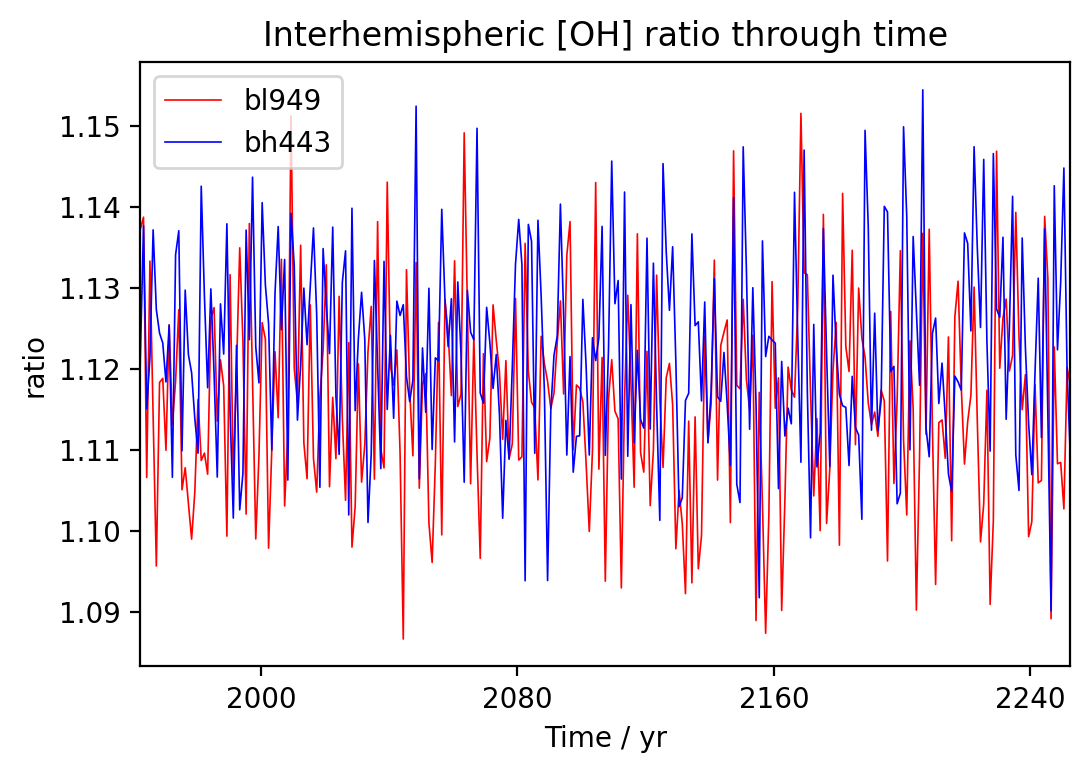

In [7]:
# Plot interhemispheric ratio over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('Interhemispheric [OH] ratio through time')

ax.plot(time_949,ratio_949,linewidth=0.6,label='bl949',c='r')
ax.plot(time_443,ratio_443,linewidth=0.6,label='bh443',c='b')

ax.set_ylabel('ratio')
ax.set_xlabel('Time / yr')

ax.set_xlim(dtime_949[0],dtime_443[-1])

plt.legend()

Text(0.5, 1.0, 'Difference in interhemispheric [OH] ratio')

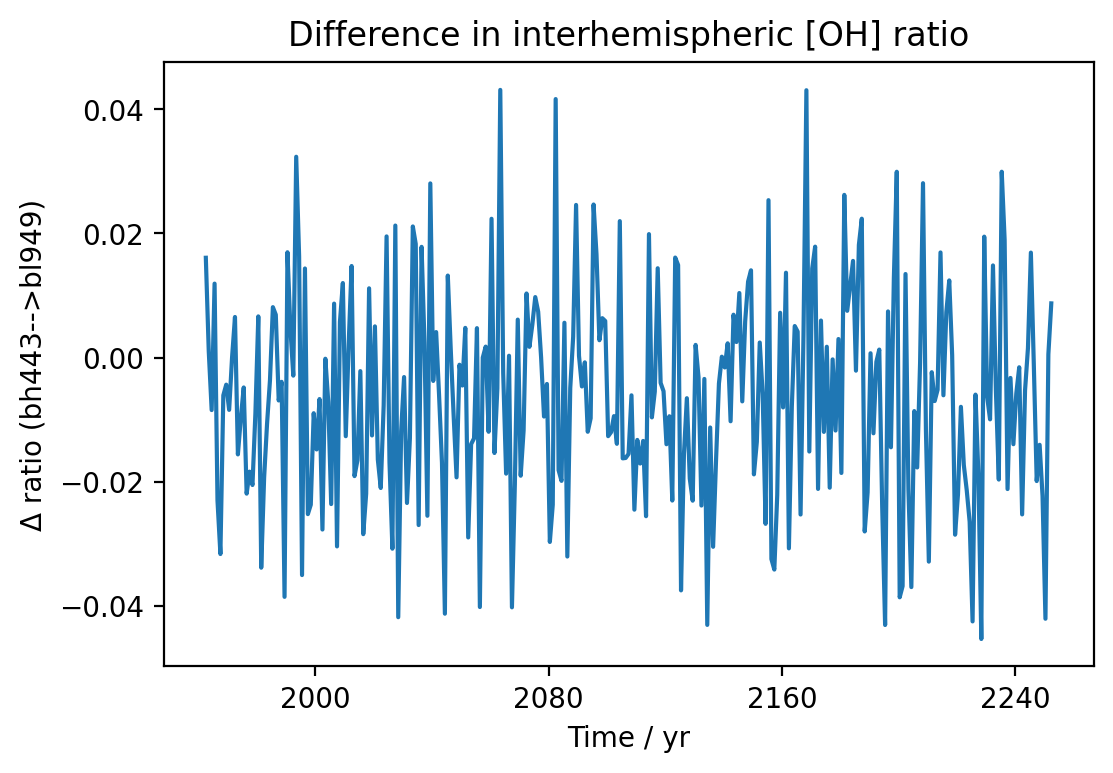

In [8]:
# Difference doesn't appear to show much or be very interesting
ratio_diff = ratio_949[:-88] - ratio_443[10:]

# Plot interhemispheric ratio over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()

ax.plot(time_949[:-88],ratio_diff)
ax.set_ylabel('\u0394 ratio (bh443-->bl949)')
ax.set_xlabel('Time / yr')

plt.title('Difference in interhemispheric [OH] ratio')

# Calculate methane interhemispheric gradient

In [7]:
# fetch methane data for the two models
ch4_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_PI.nc',chunks={'time':24})
ch4_949 = ch4_data_949[stash_ch4][:]

ch4_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_ch4.nc',chunks={'time':24})
ch4_443 = ch4_data_443['ch4'][:]

In [8]:
# Convert both to ppb then calculate hemisphere averages with latitude scaling
ppb_ch4_949 = ppb(ch4_949,mr_ch4)
ppb_ch4_443 = ppb(ch4_443,mr_ch4)

# Calculate NH and SH mean [OH]
# bl949
lon_nh_ch4_949 = dd.array.average(ppb_ch4_949.loc[:,:,0:90,:],weights=trop_949.loc[:,:,0:90,:],axis=(1,3))
nh_ch4_949 = dd.array.average(lon_nh_ch4_949,weights=lat_area_scaled[72:144],axis=1)

lon_sh_ch4_949 = dd.array.average(ppb_ch4_949.loc[:,:,-90:0,:],weights=trop_949.loc[:,:,-90:0,:],axis=(1,3))
sh_ch4_949 = dd.array.average(lon_sh_ch4_949,weights=lat_area_scaled[0:72],axis=1)

# bh443
lon_nh_ch4_443 = dd.array.average(ppb_ch4_443.loc[:,:,0:90,:],weights=trop_443.loc[:,:,0:90,:],axis=(1,3))
nh_ch4_443 = dd.array.average(lon_nh_ch4_443,weights=lat_area_scaled[72:144],axis=1)

lon_sh_ch4_443 = dd.array.average(ppb_ch4_443.loc[:,:,-90:0,:],weights=trop_443.loc[:,:,-90:0,:],axis=(1,3))
sh_ch4_443 = dd.array.average(lon_sh_ch4_443,weights=lat_area_scaled[0:72],axis=1)

gradient_949 = np.subtract(nh_ch4_949,sh_ch4_949).compute()
gradient_443 = np.subtract(nh_ch4_443,sh_ch4_443).compute()

Text(0.5, 1.0, 'Methane concentration over latitude')

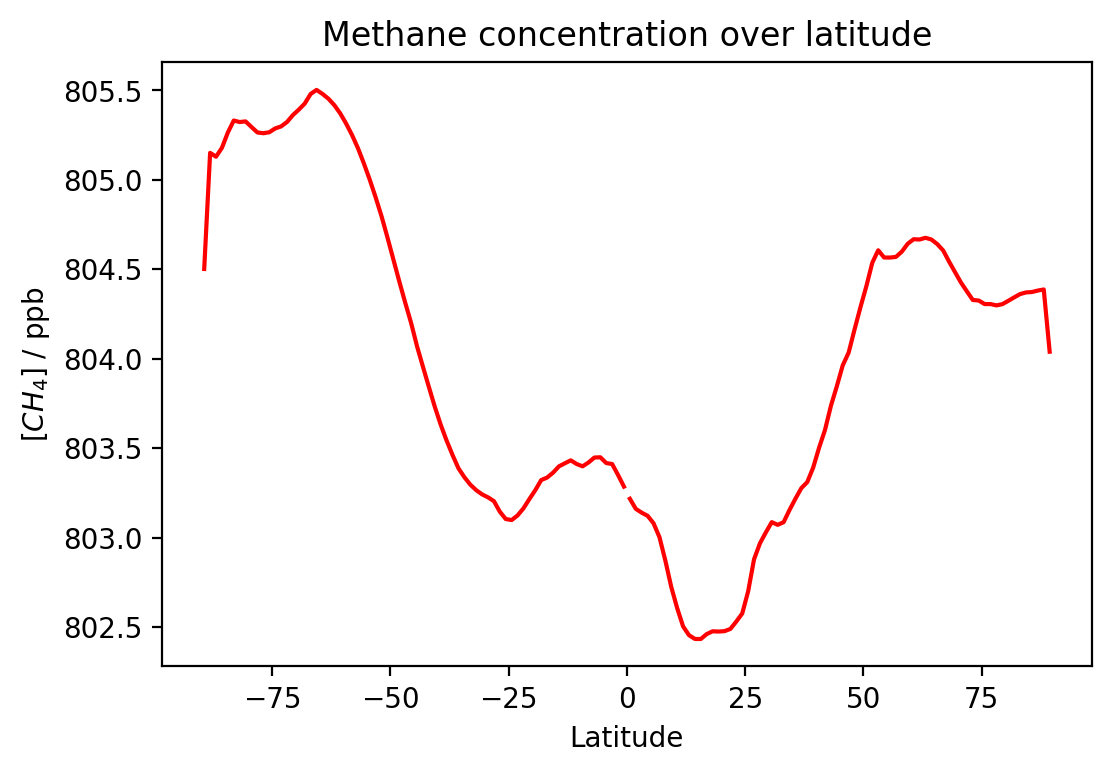

In [11]:
# Plot surface interhemispheric gradient over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()

ax.plot(ppb_ch4_949.latitude.loc[0:90],np.mean(lon_nh_ch4_949,axis=0),c='r')
ax.plot(ppb_ch4_949.latitude.loc[-90:0],np.mean(lon_sh_ch4_949,axis=0),c='r')


ax.set_ylabel('[$CH_4$] / ppb')
ax.set_xlabel('Latitude')

plt.title('Methane concentration over latitude')

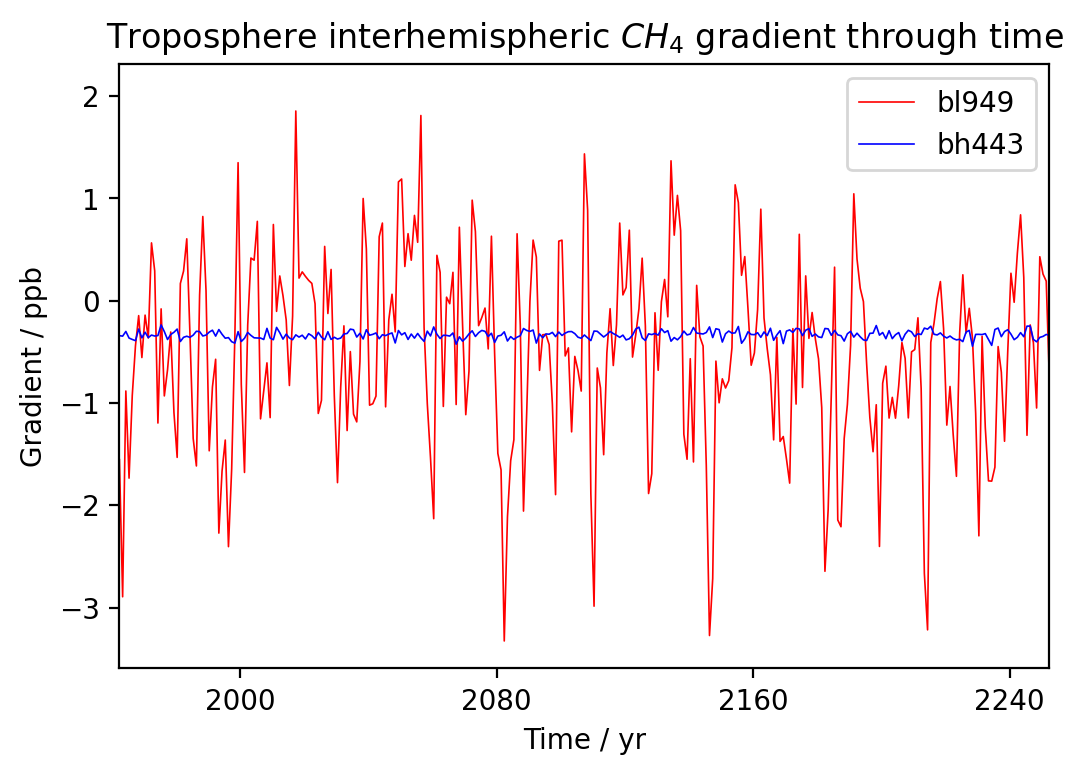

In [12]:
# Plot interhemispheric gradient over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('Troposphere interhemispheric $CH_4$ gradient through time')

ax.plot(time_949,gradient_949,linewidth=0.6,label='bl949',c='r')
ax.plot(time_443,gradient_443,linewidth=0.6,label='bh443',c='b')

ax.set_ylabel('Gradient / ppb')
ax.set_xlabel('Time / yr')

ax.set_xlim(dtime_949[0],dtime_443[-1])

plt.legend()

### Calculate surface CH4 gradient also

In [8]:
# Calculate the surface gradient to show zero as expected
nh_surf_ch4_949 = np.mean(np.average(ppb_ch4_949.loc[:,1,0:90,:],weights=lat_area_scaled[72:144],axis=1),axis=1)
sh_surf_ch4_949 = np.mean(np.average(ppb_ch4_949.loc[:,1,-90:0,:],weights=lat_area_scaled[0:72],axis=1),axis=1)

nh_surf_ch4_443 = np.mean(np.average(ppb_ch4_443.loc[:,1,0:90,:],weights=lat_area_scaled[72:144],axis=1),axis=1)
sh_surf_ch4_443 = np.mean(np.average(ppb_ch4_443.loc[:,1,-90:0,:],weights=lat_area_scaled[0:72],axis=1),axis=1)

surf_gradient_949 = nh_surf_ch4_949 - sh_surf_ch4_949
surf_gradient_443 = nh_surf_ch4_443 - sh_surf_ch4_443

Text(0.5, 1.0, 'Methane concentration over latitude')

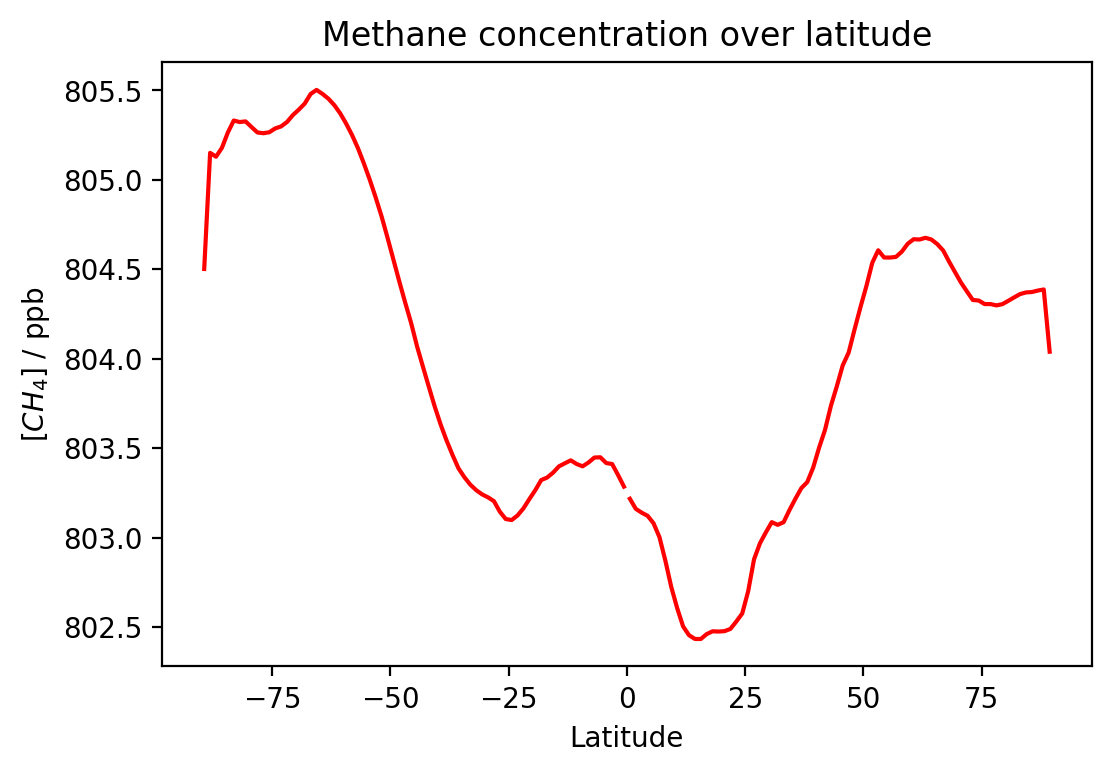

In [14]:
# Plot surface interhemispheric gradient over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()

ax.plot(ppb_ch4_949.latitude.loc[-90:0],np.mean(lon_sh_ch4_949,axis=0),c='r')
ax.plot(ppb_ch4_949.latitude.loc[0:90],np.mean(lon_nh_ch4_949,axis=0),c='r')

ax.set_ylabel('[$CH_4$] / ppb')
ax.set_xlabel('Latitude')

plt.title('Methane concentration over latitude')

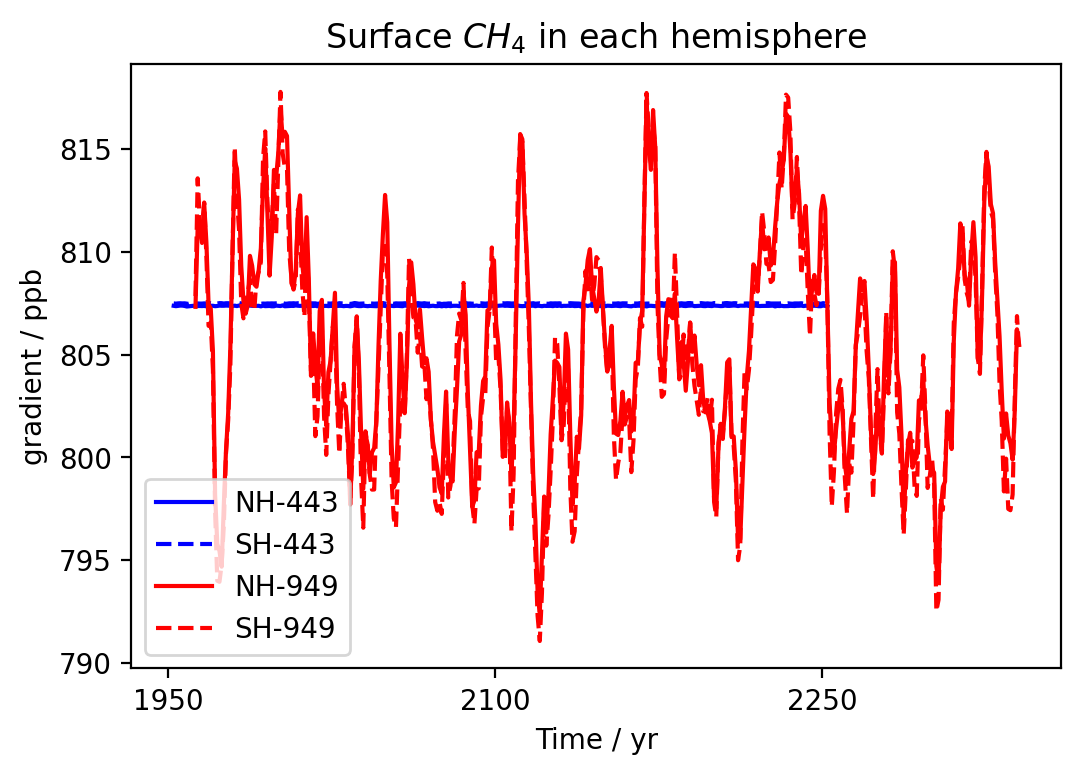

In [15]:
# Plot surface interhemispheric gradient over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()

ax.plot(time_443,nh_surf_ch4_443,label='NH-443',c='b')
ax.plot(time_443,sh_surf_ch4_443,label='SH-443', linestyle='dashed',c='b')

ax.plot(time_949,nh_surf_ch4_949,label='NH-949',c='r')
ax.plot(time_949,sh_surf_ch4_949,label='SH-949', linestyle='dashed',c='r')

ax.set_ylabel('gradient / ppb')
ax.set_xlabel('Time / yr')

plt.title('Surface $CH_4$ in each hemisphere')
plt.legend()

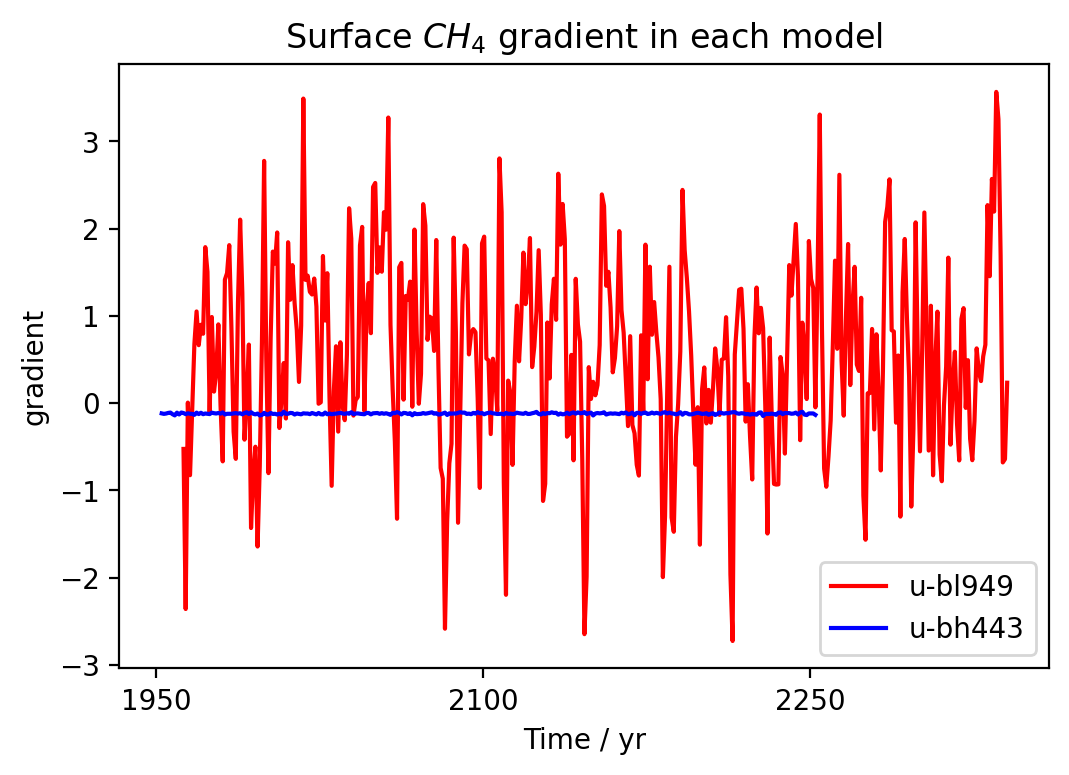

In [16]:
# Plot surface interhemispheric gradient over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()

ax.plot(time_949,surf_gradient_949,label='u-bl949',c='r')
ax.plot(time_443,surf_gradient_443,label='u-bh443',c='b')
ax.set_ylabel('gradient')
ax.set_xlabel('Time / yr')

plt.title('Surface $CH_4$ gradient in each model')
plt.legend()

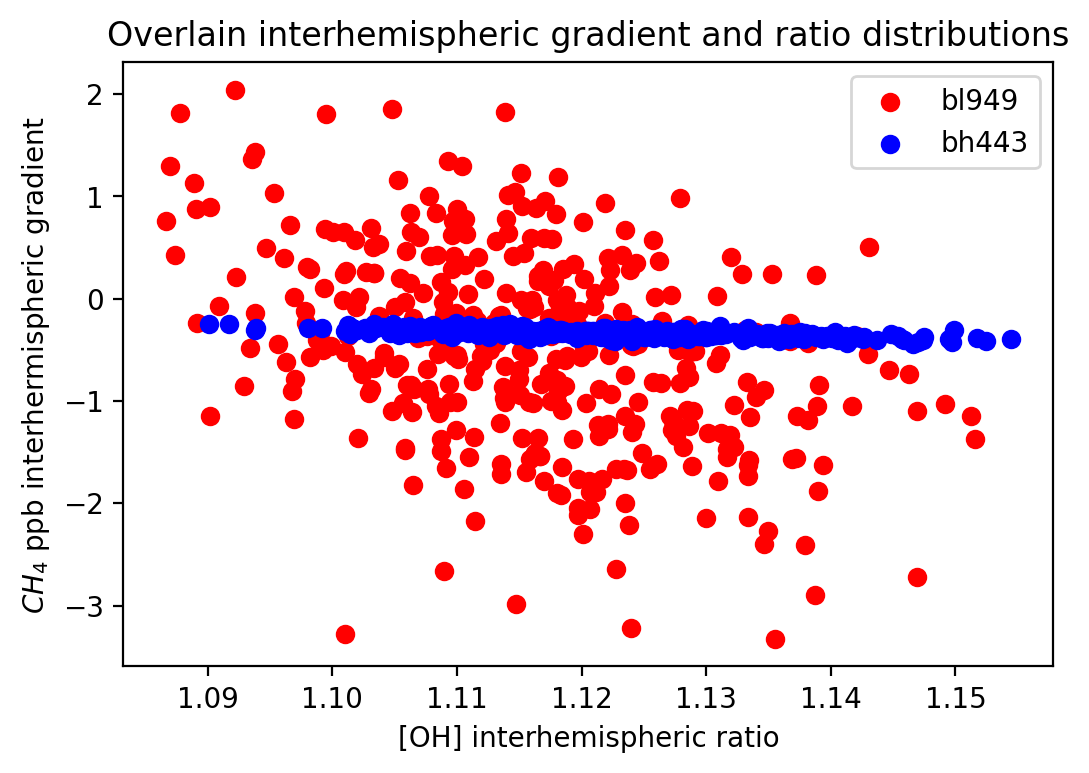

In [17]:
# Plot ratio with gradient to look for correlations
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('Overlain interhemispheric gradient and ratio distributions')

ax.scatter(ratio_949,gradient_949,label='bl949',c='r')
ax.scatter(ratio_443,gradient_443,label='bh443',c='b')

ax.set_xlabel('[OH] interhemispheric ratio')
ax.set_ylabel('$CH_4$ ppb interhermispheric gradient')

plt.legend()

# ax.scatter(ratio_diff,gradient_diff) # Plotting this shows there is no link between the differences

In [9]:
# Calculate statistical quantities to add to scatter plot

mean_grad_949 = np.mean(gradient_949)
mean_ratio_949 = np.mean(ratio_949)
std_grad_949 = np.std(gradient_949)
std_ratio_949 = np.std(ratio_949)

mean_grad_443 = np.mean(gradient_443)
mean_ratio_443 = np.mean(ratio_443)
std_grad_443 = np.std(gradient_443)
std_ratio_443 = np.std(ratio_443)

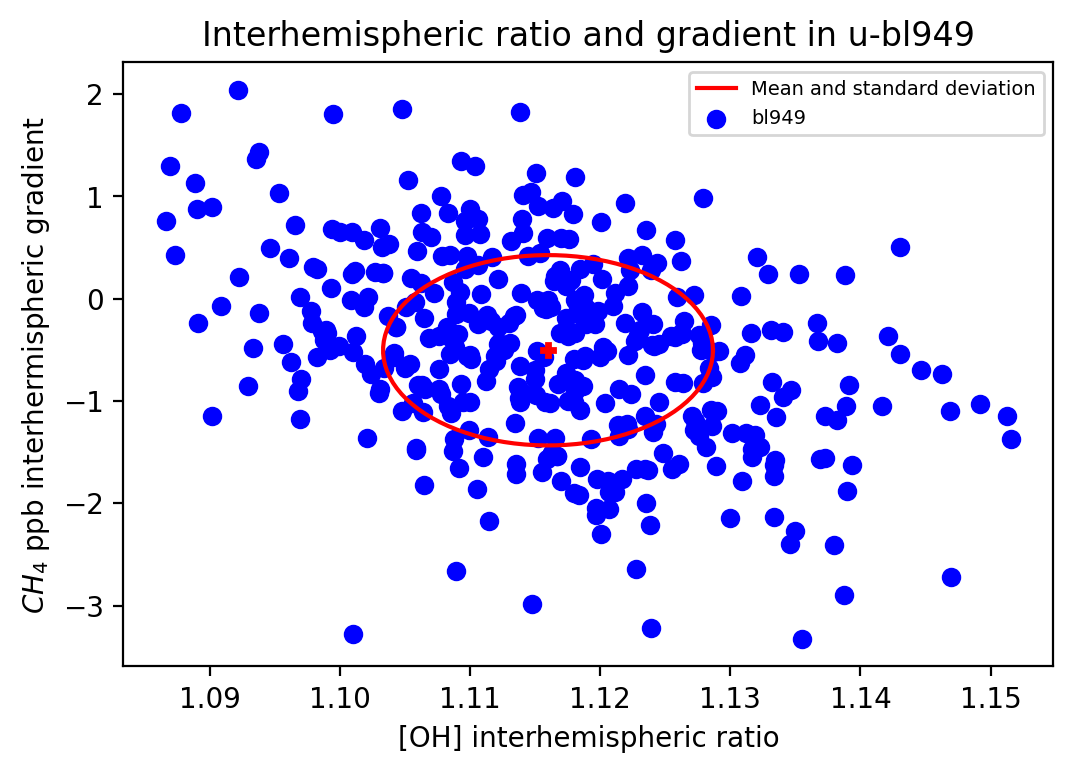

In [19]:
# Plot ratio with gradient, then add mean and std as an ellipse
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('Interhemispheric ratio and gradient in u-bl949')

ax.scatter(ratio_949,gradient_949,label='bl949',c='b')

# Plot mean and std
t = np.linspace(0,2*np.pi,100)
plt.plot(mean_ratio_949+std_ratio_949*np.cos(t),mean_grad_949+std_grad_949*np.sin(t),c='red',label='Mean and standard deviation')
plt.plot(mean_ratio_949,mean_grad_949,c='red',marker='P',markersize=5)

ax.set_xlabel('[OH] interhemispheric ratio')
ax.set_ylabel('$CH_4$ ppb interhermispheric gradient')
# ax.set_xlim(1.02,1.092)
# ax.set_ylim(8,27.5)

plt.legend(fontsize=7,loc = 'upper right')

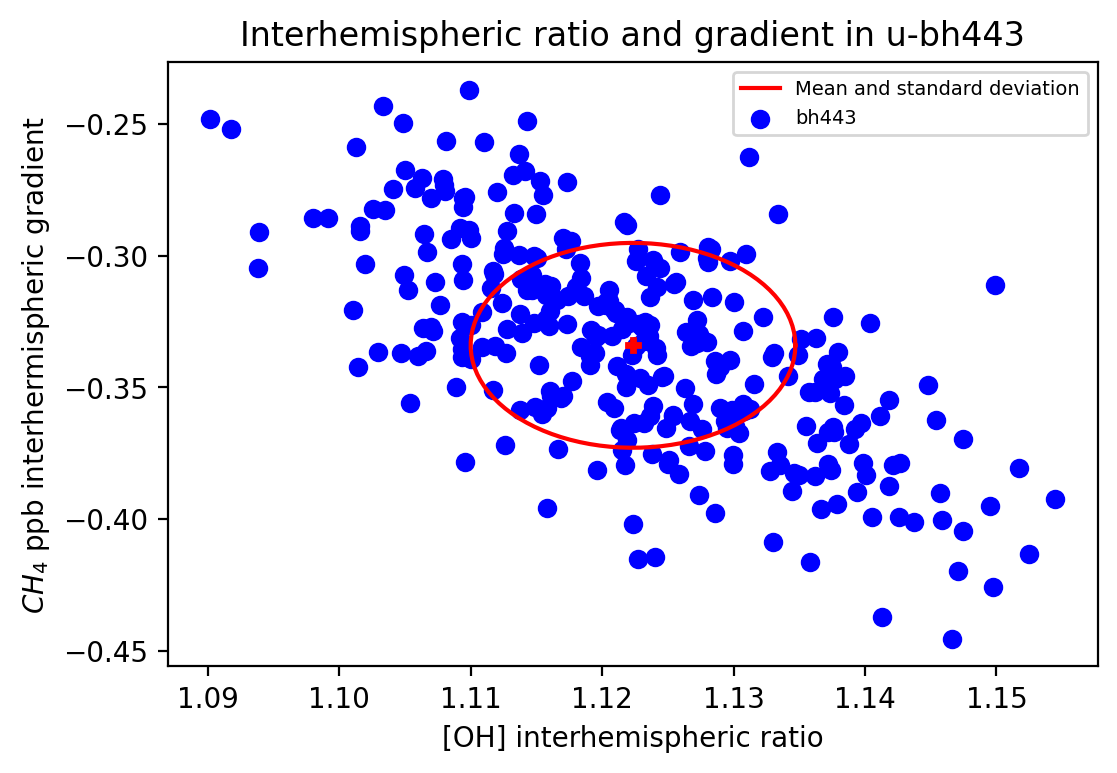

In [20]:
# Plot ratio with gradient, then add mean and std as an ellipse
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('Interhemispheric ratio and gradient in u-bh443')

ax.scatter(ratio_443,gradient_443,label='bh443',c='b')

# Plot mean and std
t = np.linspace(0,2*np.pi,100)
plt.plot(mean_ratio_443+std_ratio_443*np.cos(t),mean_grad_443+std_grad_443*np.sin(t),c='red',label='Mean and standard deviation')
plt.plot(mean_ratio_443,mean_grad_443,c='red',marker='P',markersize=5)

ax.set_xlabel('[OH] interhemispheric ratio')
ax.set_ylabel('$CH_4$ ppb interhermispheric gradient')
# ax.set_xlim(1.02,1.092)
# ax.set_ylim(8,27.5)

plt.legend(fontsize=7,loc = 'upper right')

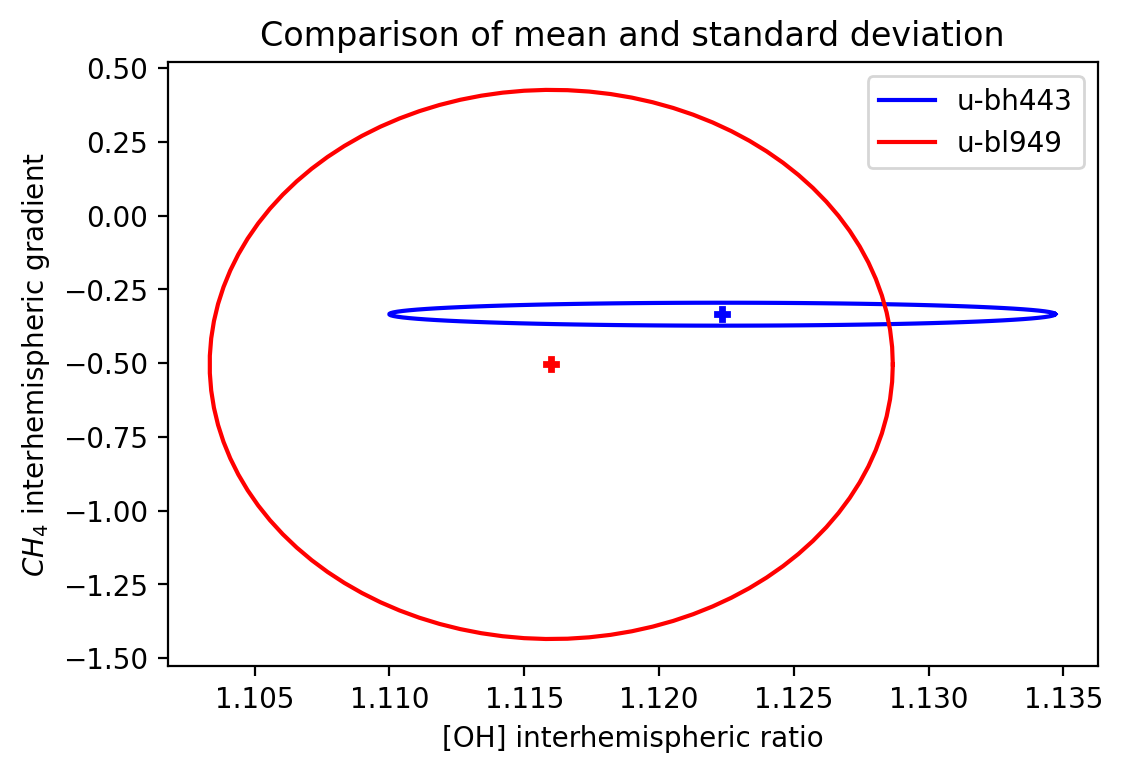

In [11]:
# Can already see the difference between the distributions using due to the large differences in plotting limits
# Now show the mean and deviation ellipses to consolidate this

fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('Comparison of mean and standard deviation')
ax.set_ylabel('$CH_4$ interhemispheric gradient')
ax.set_xlabel('[OH] interhemispheric ratio')

# Plot mean and std ellipse for both models
t = np.linspace(0,2*np.pi,100)
plt.plot(mean_ratio_443+std_ratio_443*np.cos(t),mean_grad_443+std_grad_443*np.sin(t),c='b',label='u-bh443')
plt.plot(mean_ratio_443,mean_grad_443,c='b',marker='P',markersize=5)

r = np.linspace(0,2*np.pi,100)
plt.plot(mean_ratio_949+std_ratio_949*np.cos(r),mean_grad_949+std_grad_949*np.sin(r),c='r',label='u-bl949')
plt.plot(mean_ratio_949,mean_grad_949,c='r',marker='P',markersize=5)

plt.legend()

Try to describe the sources of the difference/ dominance in interhemispheric, is it production or consumption or both?

# Create hemispheric anomalies for correlation to ratio

In [11]:
nh_anom_949 = np.multiply((nh_oh_949 - np.mean(nh_oh_949,axis=0))/np.mean(nh_oh_949,axis=0),100)
nh_anom_949 = nh_anom_949.compute()
sh_anom_949 = np.multiply((sh_oh_949 - np.mean(sh_oh_949,axis=0))/np.mean(sh_oh_949,axis=0),100)
sh_anom_949 = sh_anom_949.compute()
ratio_anom_949 = np.multiply((ratio_949 - np.mean(ratio_949,axis=0))/np.mean(ratio_949,axis=0),100)

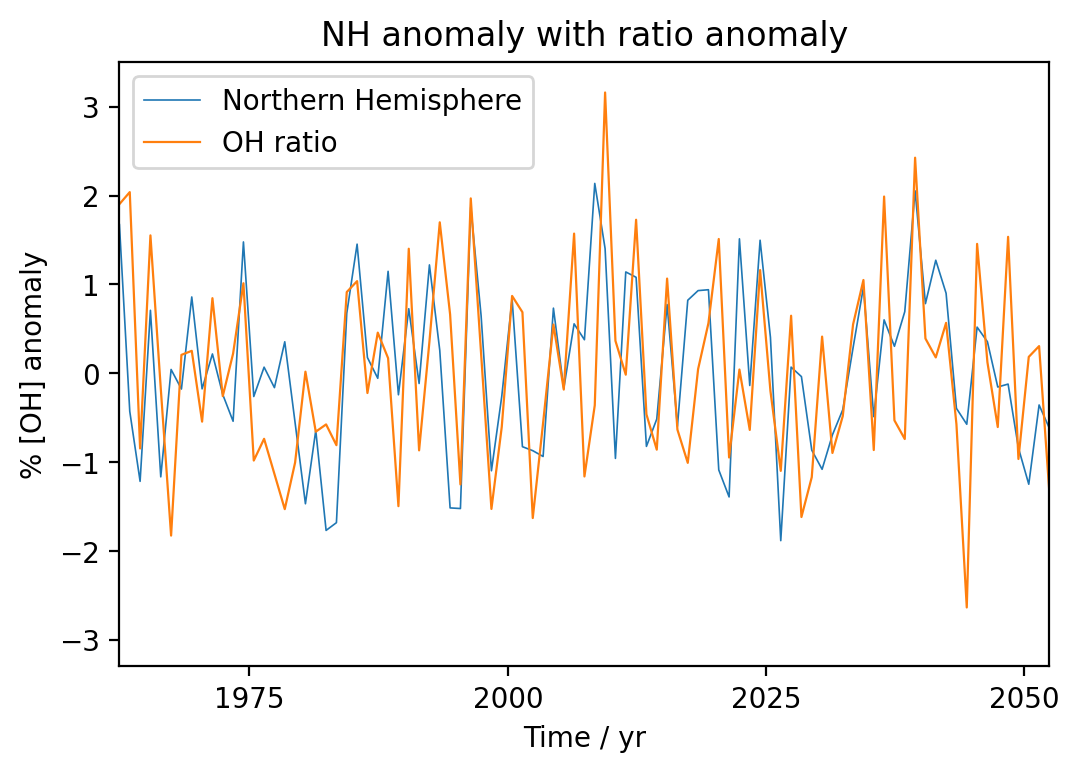

In [21]:
# Plot interhemispheric ratio over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('NH anomaly with ratio anomaly')

ax.plot(time_949,nh_anom_949,linewidth=0.6,label='Northern Hemisphere')
# ax.plot(time_949,sh_anom_949,linewidth=0.6,label='Southern Hemisphere')
ax.plot(time_949,ratio_anom_949,linewidth=0.8,label='OH ratio')

ax.set_ylabel('% [OH] anomaly')
ax.set_xlabel('Time / yr')

ax.set_xlim(dtime_949[0],dtime_443[100])

plt.legend()

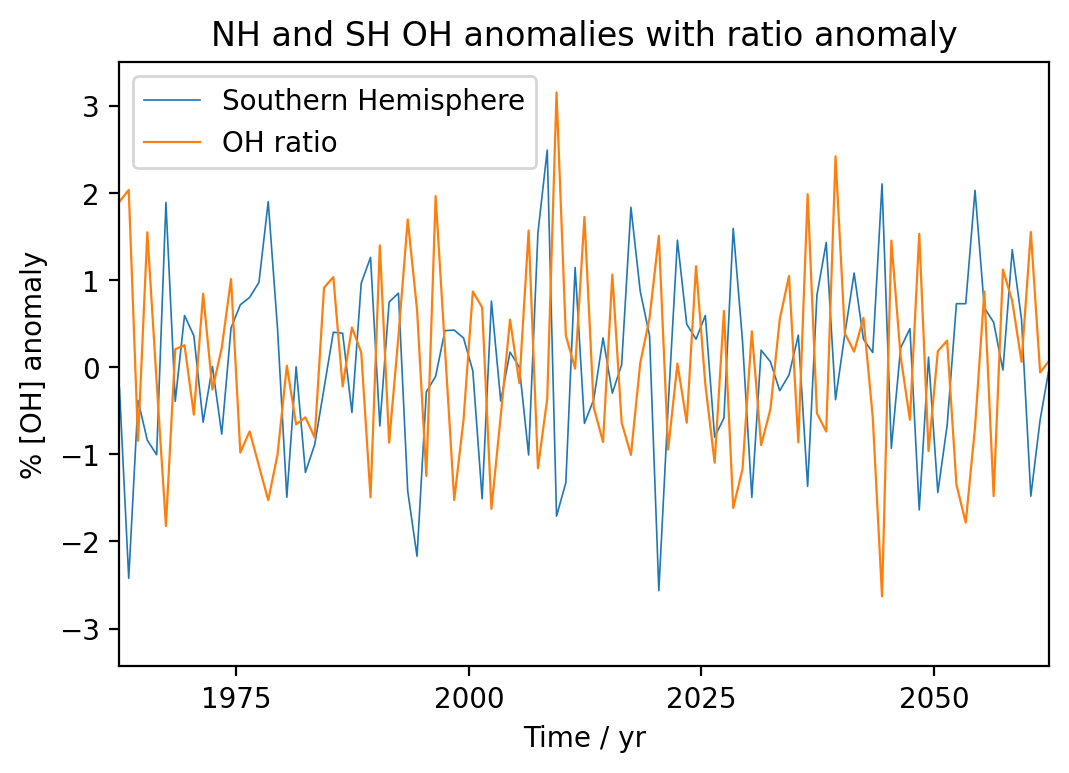

In [27]:
# Plot interhemispheric ratio over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('NH and SH OH anomalies with ratio anomaly')

# ax.plot(time_949,nh_anom_949,linewidth=0.6,label='Northern Hemisphere')
ax.plot(time_949,sh_anom_949,linewidth=0.6,label='Southern Hemisphere')
ax.plot(time_949,ratio_anom_949,linewidth=0.8,label='OH ratio')

ax.set_ylabel('% [OH] anomaly')
ax.set_xlabel('Time / yr')

ax.set_xlim(dtime_949[0],dtime_949[100])

plt.legend()

### Comparison of the NH and SH correlations to the ratio shows that SH is more important in deciding the values

In [27]:
from scipy.stats import pearsonr

In [14]:
print('OH ratio-NH OH correlation:' + str(pearsonr(nh_anom_949,ratio_anom_949)))

OH ratio-NH OH correlation:(0.4868269673379306, 6.002257803650504e-24)


In [15]:
print('OH ratio-SH OH correlation' + str(pearsonr(sh_anom_949,ratio_anom_949)))

OH ratio-SH OH correlation(-0.633525491531034, 6.404873382565961e-44)


# Compare emissions data to gradient and ratio

In [6]:
# Import emissions data

ems_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_tot_ems_PI.nc',chunks={'time':24})
ems_949 = ems_data_949[stash_ems][:]
wet_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_wet_ems_PI.nc',chunks={'time':24})
wet_949 = wet_data_949[stash_ems][:]

In [21]:
#function to convert emissions from kg m-2 s-1 to tg per year globally
def ems_convert_tg_yr(ems, farea):#emissions in kg m-2 s-1
    per_sec_to_per_yr = 60*60*24*360 #define conversion factor
    ems_kg_s = np.multiply(ems, np.array(farea)) #emissions per box
    ems_kg_yr = ems_kg_s*per_sec_to_per_yr
    ems_nh_tg_yr = np.sum(ems_kg_yr[:,72:,:], axis=(1,2))/1e9
    ems_sh_tg_yr = np.sum(ems_kg_yr[:,:72,:], axis=(1,2))/1e9
    return ems_nh_tg_yr, ems_sh_tg_yr

In [8]:
# Convert from kg m-2 s-1 to Tg yr-1 m-2, then create emissions anomaly information
nh_wet_949,sh_wet_949 = ems_convert_tg_yr(wet_949,box_area)

In [9]:
sh_wet_anom = sh_wet_949 - np.mean(sh_wet_949,axis=0)
nh_wet_anom = nh_wet_949 - np.mean(nh_wet_949,axis=0)

In [21]:
print('gradient to                   r =                  p = \nNH wetland emission anomaly:',
    str(pearsonr(nh_wet_anom,gradient_949)) + '\nSH wetland emission anomaly: ' +
    str(pearsonr(sh_wet_anom,gradient_949))
)

gradient to                   r =                  p = 
NH wetland emission anomaly: (0.28772185462473887, 1.1709472620235696e-08)
SH wetland emission anomaly: (-0.5241085092086792, 3.9794823262036557e-28)


In [32]:
print('ratio to                   r =                  p = \nNH wetland emission anomaly:',
    str(pearsonr(nh_wet_anom,ratio_949)) + '\nSH wetland emission anomaly: ' +
    str(pearsonr(sh_wet_anom,ratio_949))
)

ratio to                   r =                  p = 
NH wetland emission anomaly: (-0.046057599536723996, 0.3712370444018913)
SH wetland emission anomaly: (0.1778653361739681, 0.0005032683897685972)


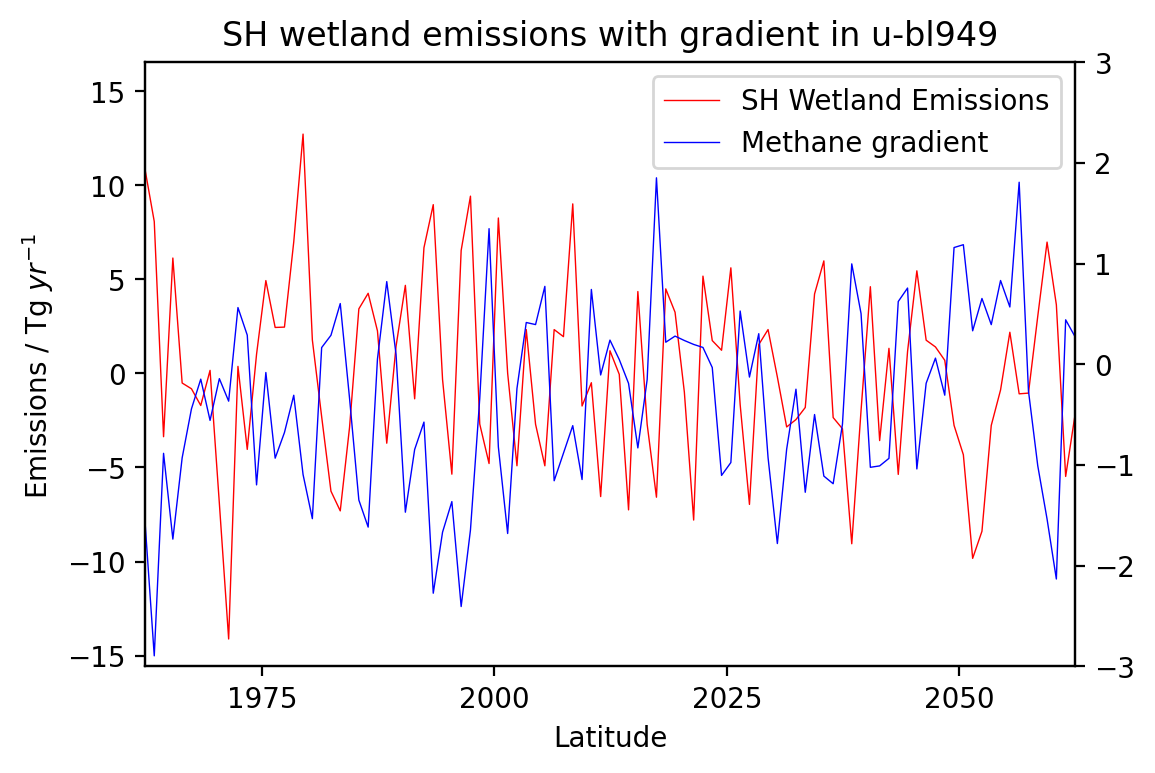

In [36]:
# Plot surface interhemispheric gradient over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()

p1, = ax.plot(wet_949.time,sh_wet_anom,label='SH Wetland Emissions',c='r',linewidth=0.5)
ax1 = ax.twinx()
p2, = ax1.plot(wet_949.time,gradient_949,label='Methane gradient',c='b',linewidth=0.5)

ax.set_ylabel('Emissions / Tg $yr^{-1}$ ')
ax.set_xlabel('Latitude')

ax.set_xlim(dtime_949[0],dtime_949[100])
ax1.set_ylim(-3,3)

plt.title('SH wetland emissions with gradient in u-bl949')
plt.legend(handles=[p1,p2])

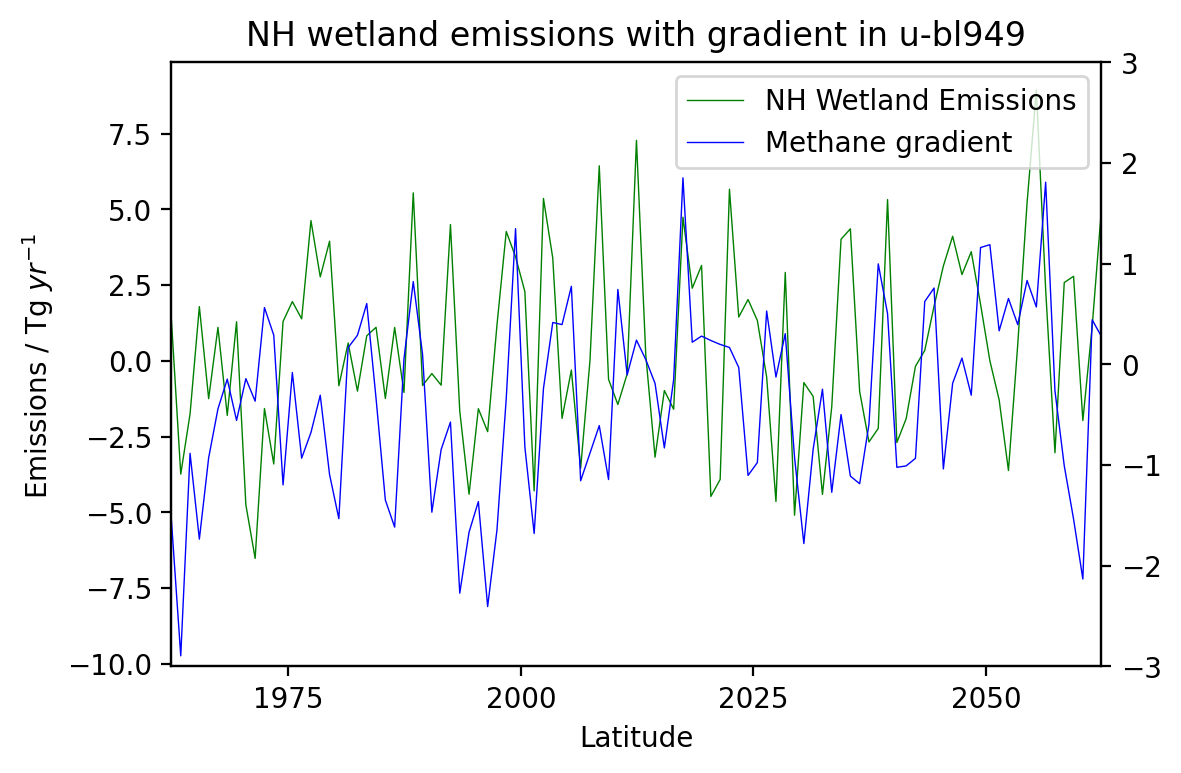

In [37]:
# Plot surface interhemispheric gradient over time for both models
fig = plt.figure(dpi=200)
ax = plt.axes()

p1, = ax.plot(wet_949.time,nh_wet_anom,label='NH Wetland Emissions',c='g',linewidth=0.5)
ax1 = ax.twinx()
p2, = ax1.plot(wet_949.time,gradient_949,label='Methane gradient',c='b',linewidth=0.5)

ax.set_ylabel('Emissions / Tg $yr^{-1}$ ')
ax.set_xlabel('Latitude')

ax.set_xlim(dtime_949[0],dtime_949[100])
ax1.set_ylim(-3,3)

plt.title('NH wetland emissions with gradient in u-bl949')
plt.legend(handles=[p1,p2])

SH emissions shown to be much more important than NH emissions in the gradient

In [4]:
## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [18]:
#function to convert emissions from kg m-2 s-1 to tg per year globally
def ems_tg_yr(ems, farea):#emissions in kg m-2 s-1
    per_sec_to_per_yr = 60*60*24*360 #define conversion factor
    ems_kg_s = np.multiply(ems, np.array(farea)) #emissions per box
    ems_kg_yr = ems_kg_s*per_sec_to_per_yr
    ems_tg_yr = np.mean(ems_kg_yr,axis=0)/1e9
    return ems_tg_yr

In [19]:
wet_map = ems_tg_yr(wet_949,box_area)

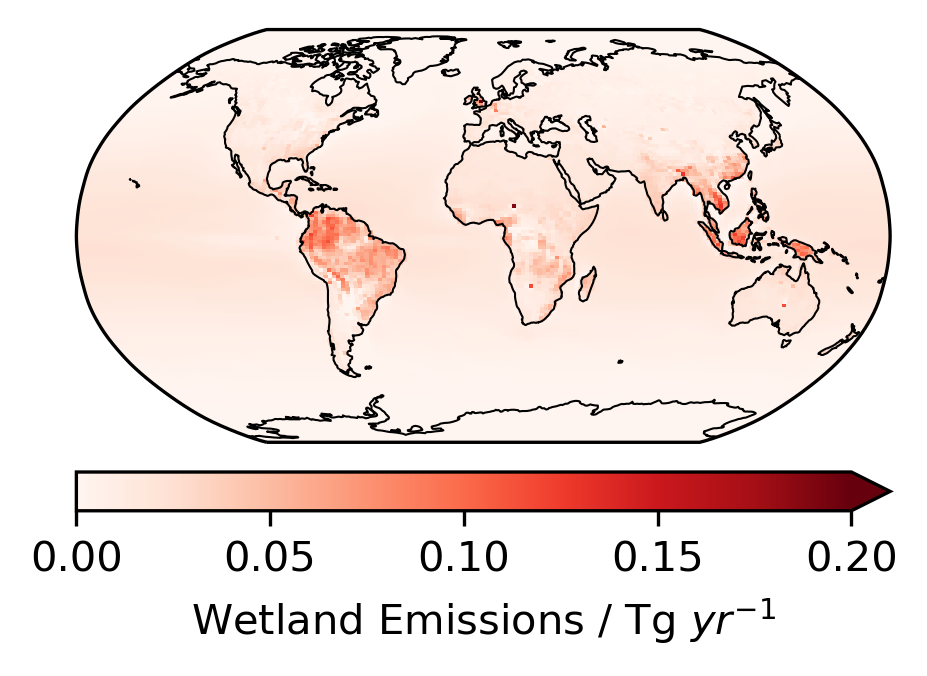

In [25]:
# show 1st eof on a map
fig = plt.figure(figsize=(3.5,2.625), dpi=300)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
ax.set_global()
ax.coastlines(linewidth=0.5)

wet_cyclic, lon_plot = add_cyclic_point(wet_map, coord=wet_map.longitude)   

plt.pcolormesh(lon_plot,wet_map.latitude,wet_cyclic, cmap='Reds',transform=ccrs.PlateCarree(central_longitude=0), vmin=0, vmax=0.2)

plt.colorbar(label = 'Wetland Emissions / Tg $yr^{-1}$' ,orientation='horizontal',pad=0.05, extend='max')

Clearly this shows wetlands are a much greater source in the SH for the PI control run, particularly in the Amazon and Indonesia

## Compare to temperature and CO to determine further dependencies

In [37]:
# Import CO data
mr_co = 28
co_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_co_PI.nc',chunks={'time':24})
co_949 = co_data_949[stash_co][:]

In [38]:
# Convert unit to molec cm3
co_molec_949 = ppb(co_949,mr_co)

In [53]:
# Calculate NH and SH averages
co_trop_949 = dd.array.average(co_molec_949,weights=trop_949,axis=1)

nh_co_949 = dd.array.average(co_trop_949[:,72:],axis=(1,2))
sh_co_949 = dd.array.average(co_trop_949[:,:72],axis=(1,2))

co_nh_anom_949 = np.multiply(np.divide(nh_co_949-np.mean(nh_co_949,axis=0),np.mean(nh_co_949,axis=0)),100)
co_sh_anom_949 = np.multiply(np.divide(sh_co_949-np.mean(sh_co_949,axis=0),np.mean(sh_co_949,axis=0)),100)

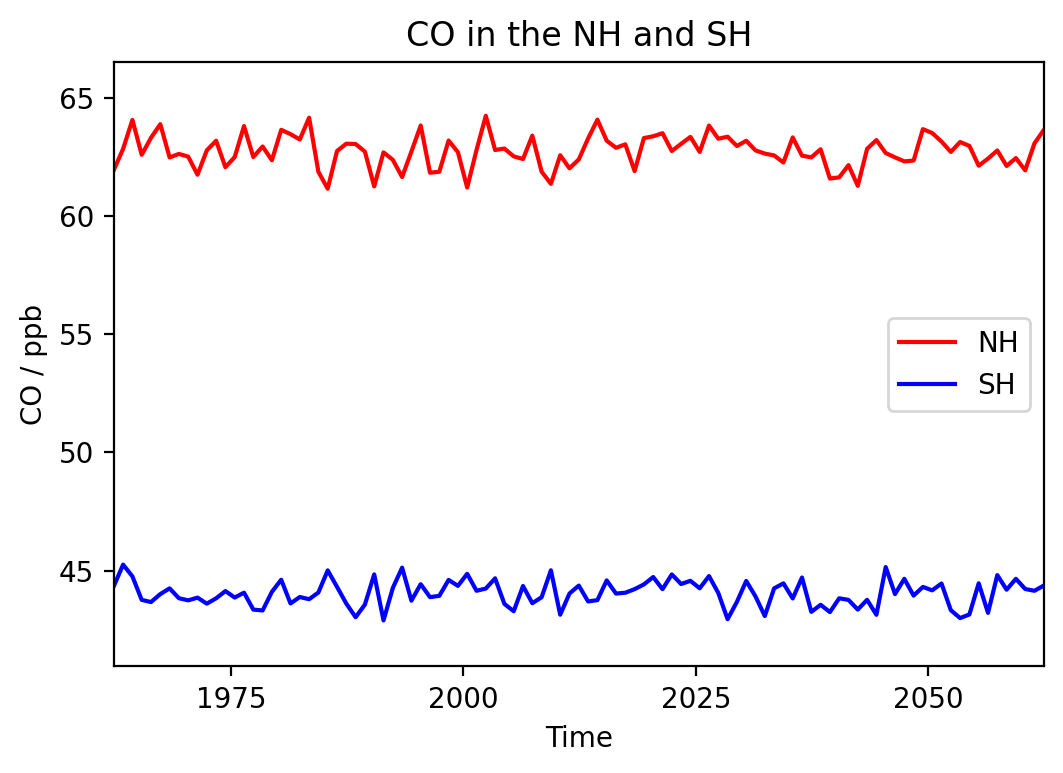

In [62]:
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('CO in the NH and SH')

ax.plot(co_949.time,nh_co_949,label='NH',c='r')
ax.plot(co_949.time,sh_co_949,label='SH',c='b')

ax.set_ylabel('CO / ppb')
ax.set_xlabel('Time')

ax.set_xlim(dtime_949[0],dtime_949[100])
plt.legend()

In [64]:
# Then find gradient and ratio correlation with CO conentration

print('gradient to                   r =                  p = \nNH CO concentration anomaly:',
    str(pearsonr(co_nh_anom_949,gradient_949)) + '\nSH CO concentration anomaly: ' +
    str(pearsonr(co_sh_anom_949,gradient_949))
)

gradient to                   r =                  p = 
NH CO concentration anomaly: (0.2900910758263217, 8.76794970558e-09)
SH CO concentration anomaly: (-0.3891352760500663, 3.7598177808487055e-15)


In [66]:
print('ratio to                      r =                  p = \nNH CO concentration anomaly:',
    str(pearsonr(co_nh_anom_949,ratio_949)) + '\nSH CO concentration anomaly: ' +
    str(pearsonr(co_sh_anom_949,ratio_949))
)

ratio to                      r =                  p = 
NH CO concentration anomaly: (-0.46087645311180025, 2.5039978871627352e-21)
SH CO concentration anomaly: (0.37913226730122096, 2.1093903030104986e-14)


Shows no correlation really, slightly correlated with the NH for ratio and SH for gradient

### Finally try comparing to surface temperature

In [72]:
# Don't use dask chunking here as overhead from chunking would probably make this process slower due to relatively small datasets
temp_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_surf_temp_1961_2340.nc')
temp_949 = temp_data_949[stash_temp][:]

temp_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_annual_mean_temp.nc')
temp_443 = temp_data_443['temp'][:]

In [89]:
# Calculate mean surface temperature in each hemisphere
temp_nh_949 = np.mean(temp_949.loc[:,0:90,:],axis=(1,2))
temp_sh_949 = np.mean(temp_949.loc[:,-90:0,:],axis=(1,2))

temp_nh_443 = np.mean(temp_443.loc[:,1,0:90,:],axis=(1,2))
temp_sh_443 = np.mean(temp_443.loc[:,1,-90:0,:],axis=(1,2))

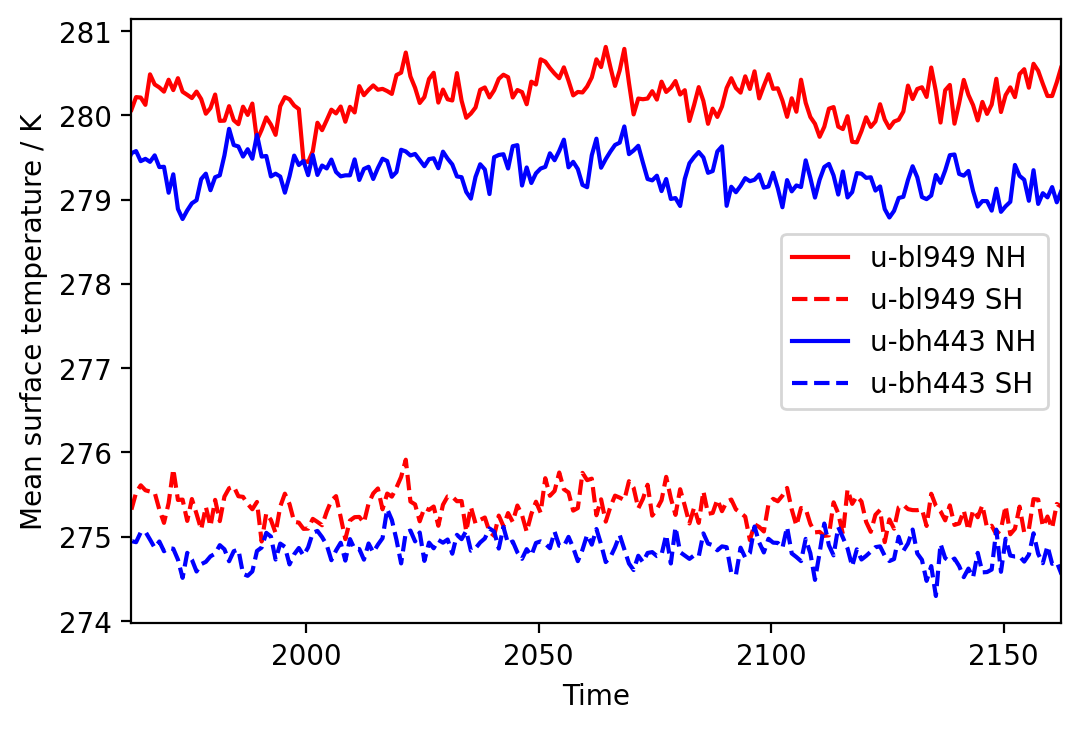

In [88]:
fig = plt.figure(dpi=200)
ax = plt.axes()

ax.plot(temp_949.time,temp_nh_949,c='r',label='u-bl949 NH')
ax.plot(temp_949.time,temp_sh_949,c='r',label='u-bl949 SH',linestyle='dashed')

ax.plot(temp_443.time,temp_nh_443,c='b',label='u-bh443 NH')
ax.plot(temp_443.time,temp_sh_443,c='b',label='u-bh443 SH',linestyle='dashed')

ax.set_xlim(dtime_949[0],dtime_949[200])
ax.set_ylabel('Mean surface temperature / K')
ax.set_xlabel('Time')

plt.legend()

In [95]:
# Compare variation in each hemisphere with temperature
print('u-bl949 gradient to      r =                  p = \nNH surface temperature:',
    str(pearsonr(temp_nh_949,gradient_949)) + '\nSH surface temperature: ' +
    str(pearsonr(temp_sh_949,gradient_949))
)
print('\nu-bh443 gradient to      r =                  p = \nNH surface temperature:',
    str(pearsonr(temp_nh_443,gradient_443)) + '\nSH surface temperature: ' +
    str(pearsonr(temp_sh_443,gradient_443))
)

u-bl949 gradient to      r =                  p = 
NH surface temperature: (0.18868134778988396, 0.00022046202030146273)
SH surface temperature: (0.08295365277044969, 0.10687908110322233)

u-bh443 gradient to      r =                  p = 
NH surface temperature: (-0.10808533270906633, 0.061082418450862694)
SH surface temperature: (-0.05696381980549901, 0.3246371839231244)


In [99]:
print('u-bl949 ratio to          r =                  p = \nNH surface temperature:',
    str(pearsonr(temp_nh_949,ratio_949)) + '\nSH surface temperature: ' +
    str(pearsonr(temp_sh_949,ratio_949))
)
print('\nu-bh443 gradient to       r =                  p = \nNH surface temperature:',
    str(pearsonr(temp_nh_443,gradient_443)) + '\nSH surface temperature: ' +
    str(pearsonr(temp_sh_443,gradient_443))
)

u-bl949 ratio to          r =                  p = 
NH surface temperature: (-0.03682411807669513, 0.47475517957507074)
SH surface temperature: (-0.03397467263639538, 0.509624874629259)

u-bh443 gradient to       r =                  p = 
NH surface temperature: (-0.10808533270906633, 0.061082418450862694)
SH surface temperature: (-0.05696381980549901, 0.3246371839231244)


Shows there is no real correlation between surface temperature and gradient or ratio in either model

Maybe would be useful to do further studies to check that temperature variations in certain areas are not more important individually however